In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.3.0


In [2]:
# !pip install -q git+https://github.com/tensorflow/docs
# 已经安装成功就不继续安装了

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


In [20]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [21]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [22]:
logdir


PosixPath('/tmp/tmp01ywhvy2/tensorboard_logs')

In [23]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [24]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label
packed_ds = ds.batch(10000).map(pack_row).unbatch()
# ds持有的是一个tuple，所以batch之后，持有的仍然是tuple
# 只不过每个tuple的元素都变成了一个(10000,)的列表
# 所以pack_row方法输入的row是一个有着29个(10000,)列表的tuple
# row[0]，就是10000个label
# row[1:]，就是(28*(10000,))的tuple。对其进行stack，就变成了(10000,28)的矩阵
# stack方法的使用请google吧

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


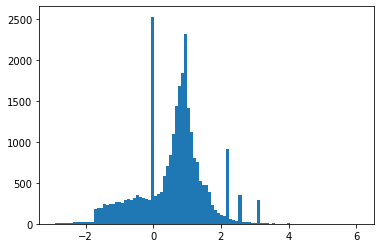

In [25]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [26]:
print(ds.batch(10000).map(pack_row))
print(packed_ds)

<MapDataset shapes: ((None, 28), (None,)), types: (tf.float32, tf.float32)>
<_UnbatchDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>


In [27]:
print(gz)
print(ds)
for row in ds.take(1):
  print(type(row))
  print(len(row))
  print(row)

for row in ds.batch(2).take(1):
    print(type(row))
    print(len(row))
    print(row)

/root/.keras/datasets/HIGGS.csv.gz
<CsvDatasetV2 shapes: ((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>
<class 'tuple'>
29
(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8692932>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.6350818>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22569026>, <tf.Tensor: shape=(), dtype=float32, numpy=0.32747006>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.6899932>, <tf.Tensor: shape=(), dtype=float32, numpy=0.75420225>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.24857314>, <tf.Ten

In [28]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [29]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [30]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [31]:
validate_ds = validate_ds.batch(BATCH_SIZE)
# train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
train_ds = train_ds.repeat().batch(BATCH_SIZE)

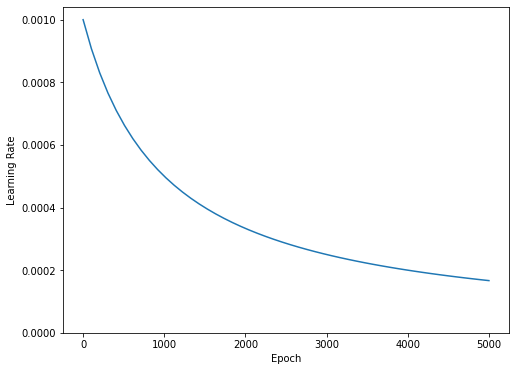

In [34]:

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [35]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    # tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss1', patience=200),
    # 教程上说这地方要用val_binary_crossentropy不能用val_loss，但实测发现，这俩其实没区别
    # val_loss的值就等于crossentropy啊
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [36]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='loss1'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [37]:
size_histories = {}

In [38]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4995,  binary_crossentropy:0.7996,  loss:0.7996,  loss1:0.7996,  val_accuracy:0.4820,  val_binary_crossentropy:0.7338,  val_loss:0.7338,  val_loss1:0.7338,  
....................................................................................................
Epoch: 100, accuracy:0.5923,  binary_crossentropy:0.6300,  loss:0.6300,  loss1:0.6300,  val_accuracy:0.5900,  val_binary_crossentropy:0.6303,  val_loss:0.6303,  val_loss1:0.6303,  
........................................................

(0.5, 0.7)

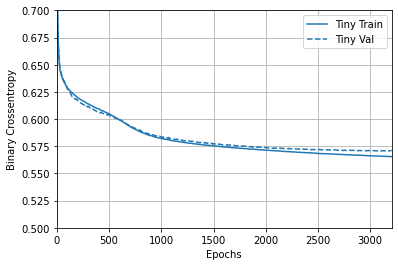

In [66]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

(0.5, 0.7)

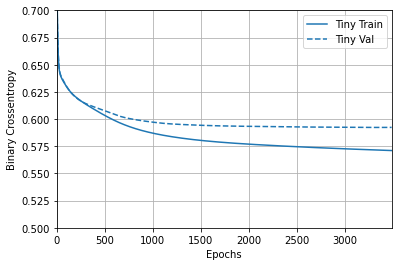

In [39]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [22]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [ ]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5089,  binary_crossentropy:0.8224,  loss:2.3507,  val_accuracy:0.4870,  val_binary_crossentr

In [ ]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),# 这个input_shape的形状是(28,)，说明这是个28元素的一维列表
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")